In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import proplot as pplt
from intakedata import Naming
import itertools
import pandas as pd
import matplotlib.patches as mpatches


In [5]:
layer_fp = "/Users/jmccarty/GitHub/parametric-bipv-app/static/data/device_layer_data.json"
impact_fp = "/Users/jmccarty/GitHub/parametric-bipv-app/static/data/device_impact_data.json"
with open(layer_fp, "r") as fp:
    layer_data = json.load(fp)
    
with open(impact_fp, "r") as fp:
    impact_data = json.load(fp)
    


In [3]:
Naming().impact_categories_units

{'climate change': 'kg CO2-Eq / sqm.',
 'energy resources: non-renewable, fossil': 'kg oil-Eq / sqm.',
 'ozone depletion': 'kg CFC-11-Eq / sqm.',
 'acidification: terrestrial': 'kg SO2-Eq / sqm.',
 'photochemical oxidant formation: human health': 'kg NOx-Eq / sqm.',
 'photochemical oxidant formation: terrestrial ecosystems': 'kg NOx-Eq / sqm.',
 'ecotoxicity: freshwater': 'kg 1,4-DCB-Eq / sqm.',
 'particulate matter formation': 'kg PM2.5-Eq / sqm.',
 'eutrophication: freshwater': 'kg P-Eq / sqm.',
 'eutrophication: marine': 'kg N-Eq / sqm.',
 'ionising radiation': 'kg Co-60-Eq / sqm.',
 'human toxicity: non-carcinogenic': '(HTPnc) kg 1,4-DCB-Eq',
 'human toxicity: carcinogenic': '(HTPc) kg 1,4-DCB-Eq',
 'land use': 'sqm. land / sqm.'}

In [89]:
plot_dict = {}

for impact_category in Naming().raw_indicators:

    plot_data = {}
    for device_type in layer_data.keys():
        device_impacts = {}
        for list_item in layer_data[device_type]:
            layer = list_item['title']
            # combinations are made up of the unique possible layer_option and location_option combinations
            device_impacts[layer] = {}
            layer_options = list_item['options'].keys()
            for layer_option in layer_options:
                
                location_options = list_item['options'][layer_option]
                for location_option in location_options:
                    option_key = "-".join([layer_option, location_option, impact_category])
                    device_impacts[layer][option_key] = impact_data[device_type][layer][layer_option][location_option][impact_category]

        # Extract all combinations of layer options
        layer_combinations = list(itertools.product(*[options.values() for options in device_impacts.values()]))

        # Calculate the sum of climate change impacts for each combination
        device_plot = [sum(combination) for combination in layer_combinations]
        plot_data[device_type] = device_plot

    plot_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in plot_data.items() ]))
    
    plot_dict[impact_category] = plot_df

In [92]:
impact_cats = ["energy resources: non-renewable, fossil",
"acidification: terrestrial",
"climate change",
"ecotoxicity: freshwater",
"eutrophication: freshwater",
"eutrophication: marine",
"human toxicity: carcinogenic",
"human toxicity: non-carcinogenic",
"ionising radiation",
"land use",
"ozone depletion",
"particulate matter formation",
"photochemical oxidant formation: human health",
"photochemical oxidant formation: terrestrial ecosystems"]

14

In [131]:
len_df = plot_dict['climate change']
for col in len_df.columns:
    s = len_df[col]
    print(col, len(s[~pd.isna(s)]))
    

organic 28512
perovskite 228096
monocrystalline 186624
polycrystalline 124416
cdte 186624
cigs 279936


['#a6cee3ff', '#b2df8aff', '#fb9a99ff', '#fdbf6fff', '#cab2d6ff', '#ffff99ff']

[]

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

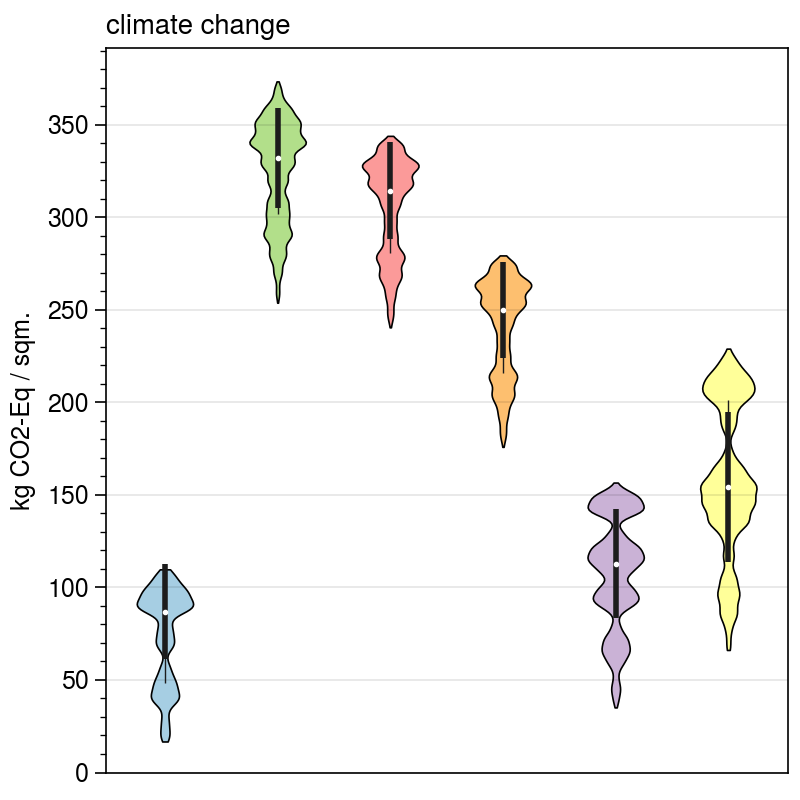

In [193]:
square_size = 4
colors = pplt.get_colors("Paired")[::2]

impact_cat = 'climate change'
fig, axe = pplt.subplots(share=False, ncols=1, nrows=1, figsize=(square_size,square_size), facecolor='white')
ax = axe[0]
ax.violin(plot_dict[impact_cat], cycle=colors, medians=True, barpctile=50,
          barc='#1c1c1c',barlw=0.5, boxms=2, boxmc='white')
ax.format(ltitle=Naming().impact_categories_short[impact_cat],
        ylabel=Naming().impact_categories_units[impact_cat],
        ymin=0)
ax.xaxis.set_ticklabels([])
ax.xaxis.set_ticks([])

In [181]:
pplt.get_colors("Paired")[0::1]

['#b2df8aff',
 '#33a02cff',
 '#fb9a99ff',
 '#e31a1cff',
 '#fdbf6fff',
 '#ff7f00ff',
 '#cab2d6ff',
 '#6a3d9aff',
 '#ffff99ff',
 '#b15928ff']

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

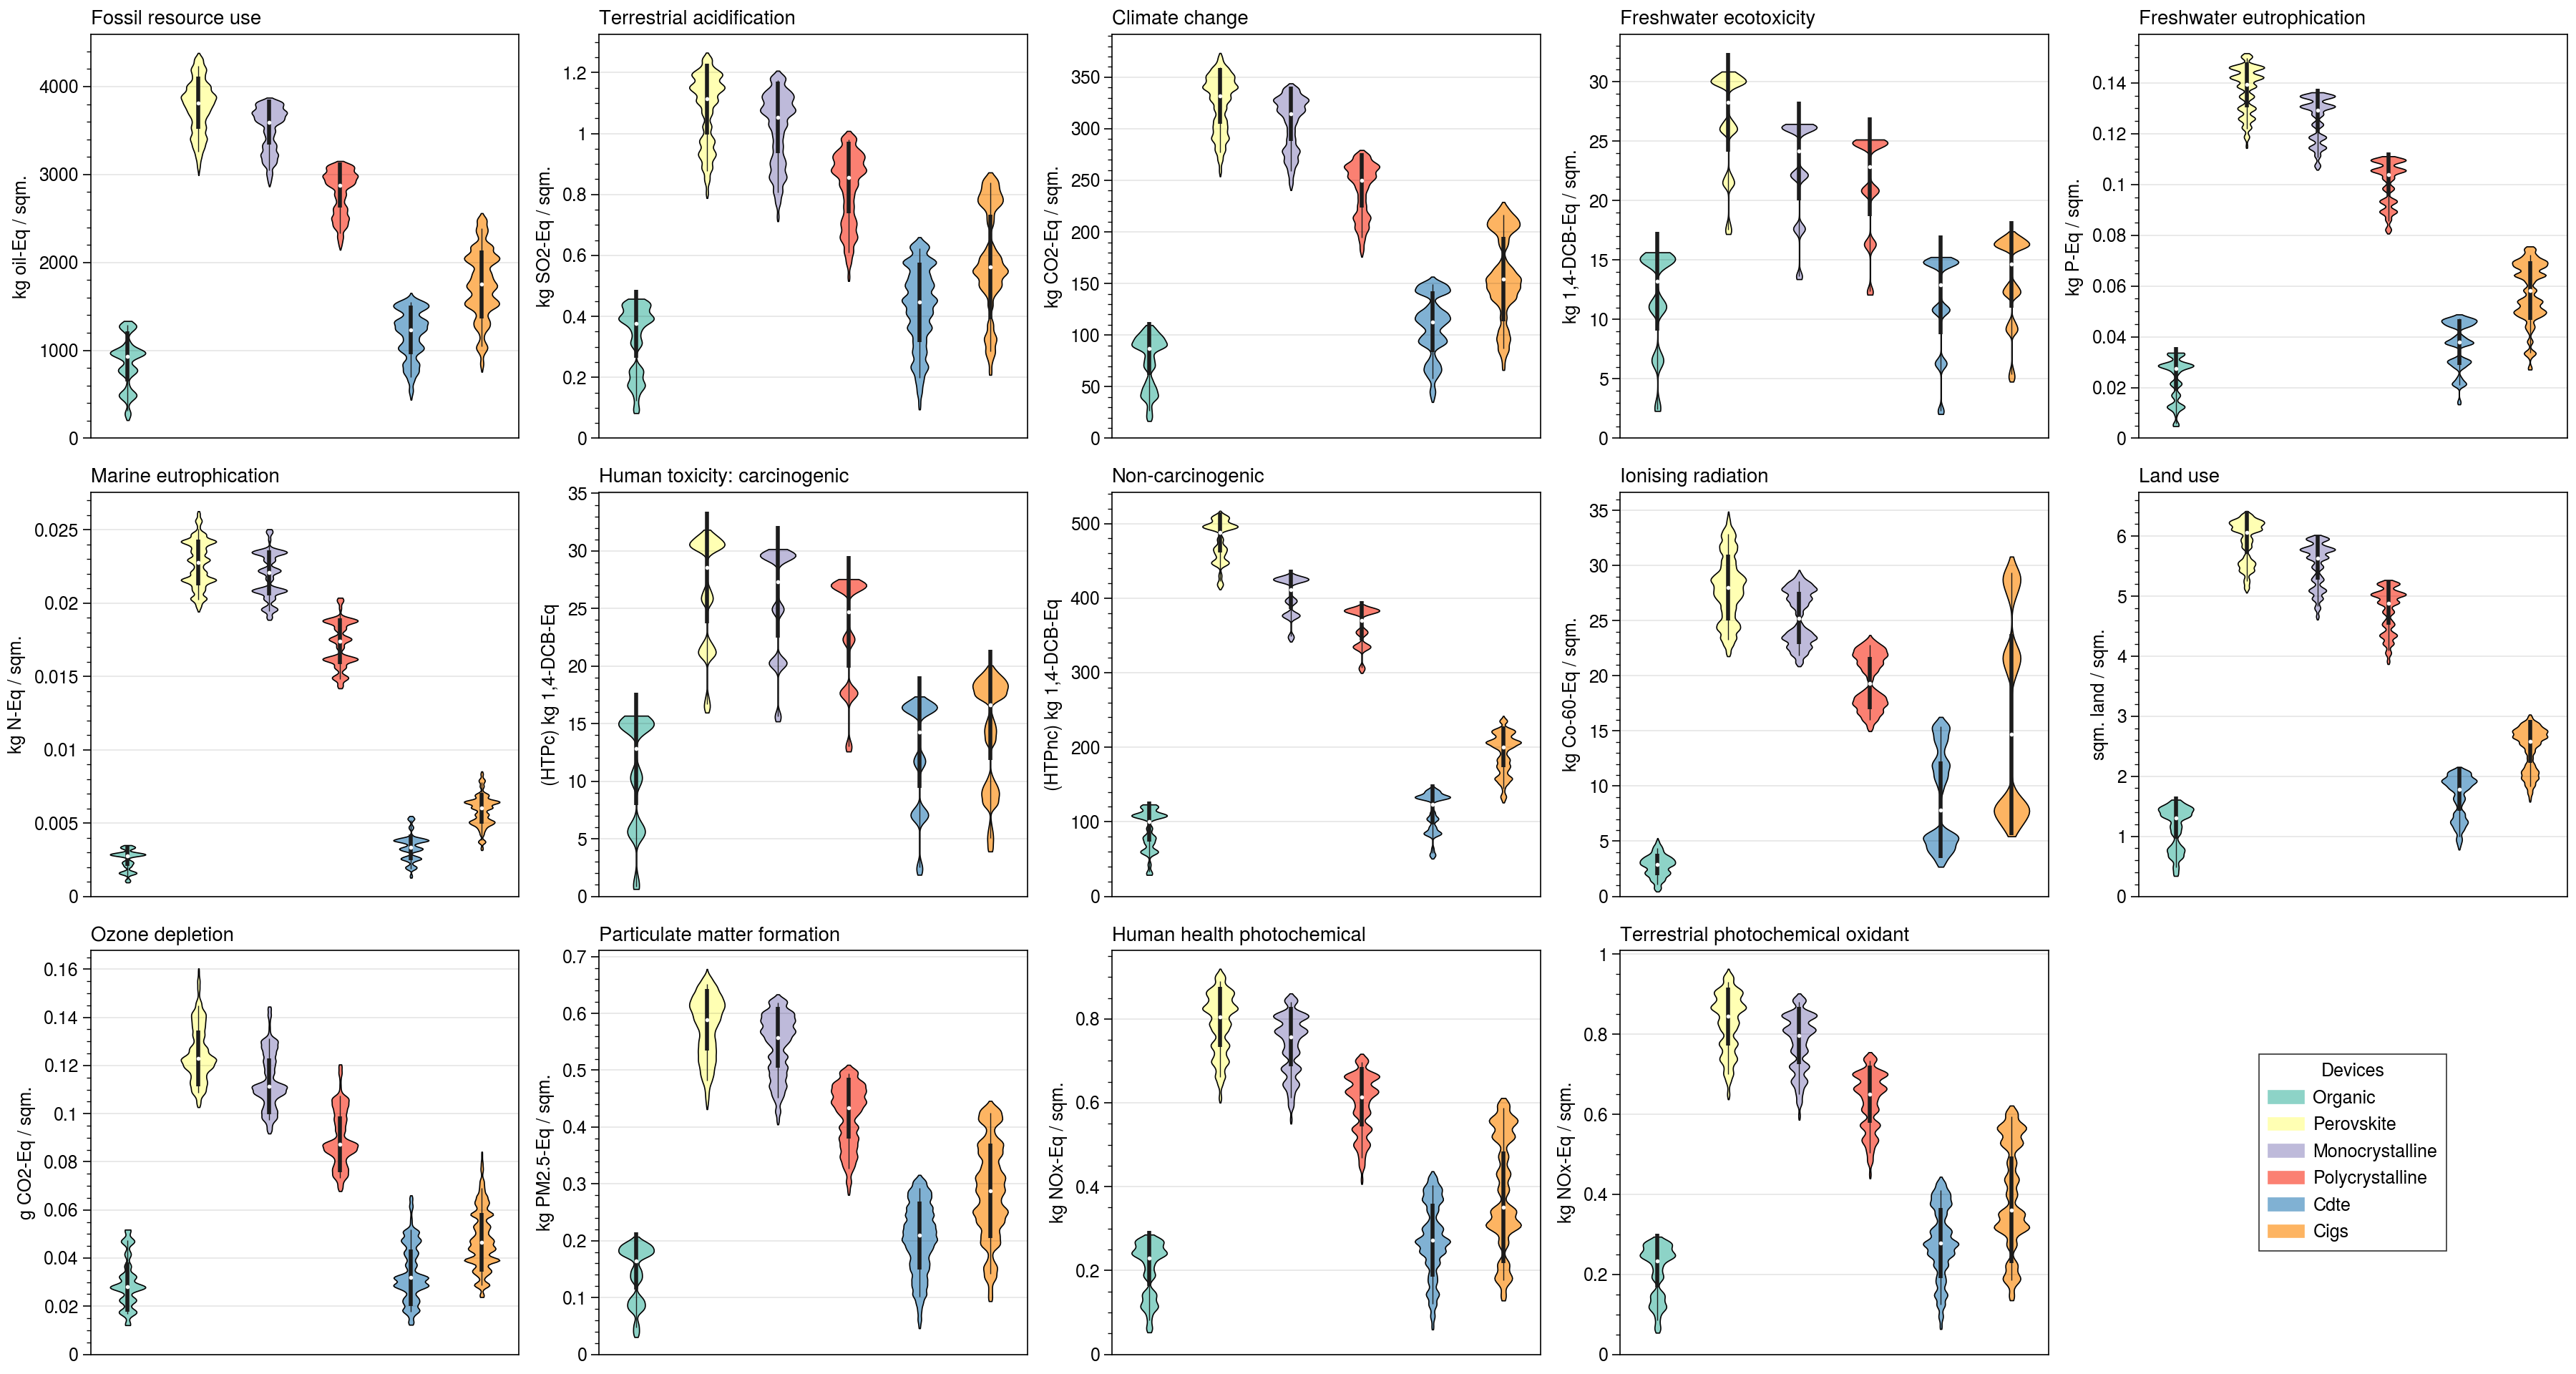

In [196]:

square_size = 4
colors = pplt.get_colors("Set3",6)#[2::2]
fig, axe = pplt.subplots(
    sharey=False, sharex=True,
    ncols=5, nrows=3, figsize=(square_size*0.9*5, square_size*0.8*3), facecolor="white")

for n, impact_cat in enumerate(impact_cats):
    ax = axe[n]

    if impact_cat == "ozone depletion":
        ylabel = "g CO2-Eq / sqm."
        violin_data = plot_dict[impact_cat] * 1000
    else:
        ylabel = Naming().impact_categories_units[impact_cat]
        violin_data = plot_dict[impact_cat]

    ax.violin(violin_data, cycle=colors, medians=True, barpctile=90,
          barc='#1c1c1c',barlw=0.5, boxms=2, boxmc='white')
    ax.format(
        ltitle=Naming().impact_categories_short[impact_cat].capitalize(), ylabel=ylabel, ymin=0
    )
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])

# axe[len(axe)-2].set_axis_off()

# # Clear bottom-right ax
lenged_ax = axe[-1] 
lenged_ax.set_axis_off()  # removes the XY axes
patches = [mpatches.Patch(color=c, label=plot_dict[impact_cat].columns[n].capitalize()) for n,c in enumerate(colors)]
lenged_ax.legend(handles=patches, loc='center',ncols=1, title='Devices')

fig.savefig(f"plots/violins/impact_cats.pdf", dpi=150)
